**STEP 1: Install and Import Required Libraries**

Before anything else, we need to install and import the packages to handle EEG data and processing.

In [ ]:
!pip install mne --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.1 MB/s eta 0:00:00


**Import and Read the Summary File**


In [ ]:
#import necessary library
import os
import re

#path to the summary file

summary_path = '/content/chb01-summary.txt'

# Function to parse seizure times from summary text
def parse_seizure_summary(path):
    seizure_dict = {}
    current_file = None
    with open(path, 'r') as file:
        for line in file:
            line = line.strip()
            # Detect file name
            if "File Name:" in line:
                current_file = line.split(":")[1].strip()
                seizure_dict[current_file] = []
            # Detect seizure start
            elif "Seizure Start Time:" in line:
                start_time = int(line.split(":")[1].strip().split()[0])
                seizure_dict[current_file].append({'start': start_time})
            # Detect seizure end
            elif "Seizure End Time:" in line:
                end_time = int(line.split(":")[1].strip().split()[0])
                if seizure_dict[current_file]:
                    seizure_dict[current_file][-1]['end'] = end_time
    return seizure_dict

# Parse the summary file
seizure_info = parse_seizure_summary(summary_path)

# Preview parsed seizure times
for k, v in seizure_info.items():
    print(f"{k}: {v}")

chb01_01.edf: []
chb01_02.edf: []
chb01_03.edf: [{'start': 2996, 'end': 3036}]
chb01_04.edf: [{'start': 1467, 'end': 1494}]
chb01_05.edf: []
chb01_06.edf: []
chb01_07.edf: []
chb01_08.edf: []
chb01_09.edf: []
chb01_10.edf: []
chb01_11.edf: []
chb01_12.edf: []
chb01_13.edf: []
chb01_14.edf: []
chb01_15.edf: [{'start': 1732, 'end': 1772}]
chb01_16.edf: [{'start': 1015, 'end': 1066}]
chb01_17.edf: []
chb01_18.edf: [{'start': 1720, 'end': 1810}]
chb01_19.edf: []
chb01_20.edf: []
chb01_21.edf: [{'start': 327, 'end': 420}]
chb01_22.edf: []
chb01_23.edf: []
chb01_24.edf: []
chb01_25.edf: []
chb01_26.edf: [{'start': 1862, 'end': 1963}]
chb01_27.edf: []
chb01_29.edf: []
chb01_30.edf: []
chb01_31.edf: []
chb01_32.edf: []
chb01_33.edf: []
chb01_34.edf: []
chb01_36.edf: []
chb01_37.edf: []
chb01_38.edf: []
chb01_39.edf: []
chb01_40.edf: []
chb01_41.edf: []
chb01_42.edf: []
chb01_43.edf: []
chb01_46.edf: []


**Load EEG Signal from One File**
We’ll use the mne library to:

Load the .edf file

View basic metadata (channels, duration, sampling rate)

In [ ]:
import mne

#path to EEG file
edf_path = '/content/chb01_03.edf'

#load the EEG files
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
#show basic info about the recording
raw.info

/tmp/ipython-input-3-619125520.py:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 13:43:04 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>

 We now know:

Sampling Rate = 256 Hz

Channels = 23

File duration = can now be computed in seconds

**Calculate Duration and Plot a Few**

Before we slice into 10-second windows, let’s:

Compute the duration of the recording

Plot a short preview (first 10 seconds) to confirm signals look okay

Recording duration: 3600.00 seconds
Using matplotlib as 2D backend.


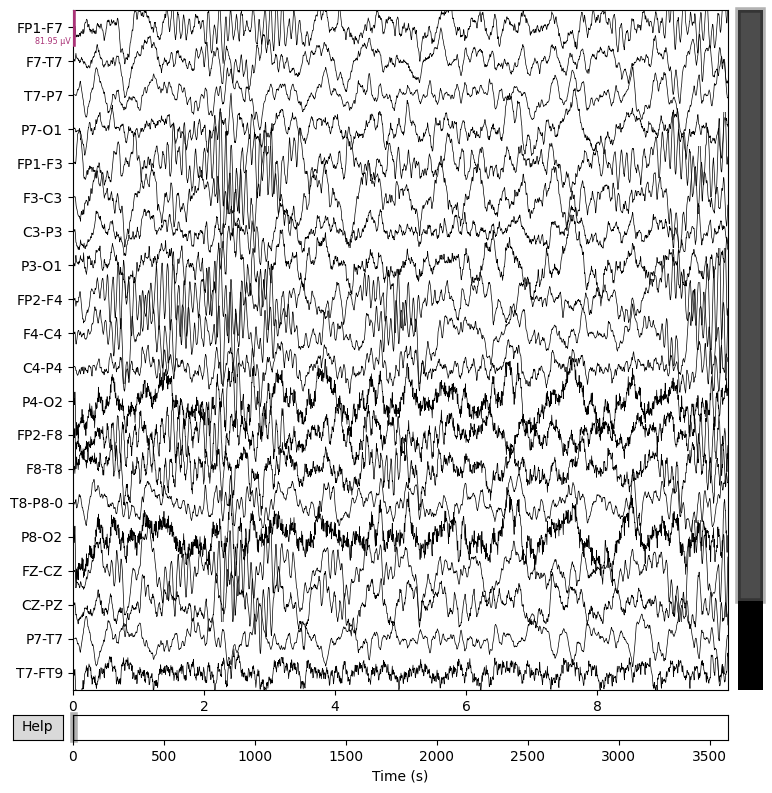

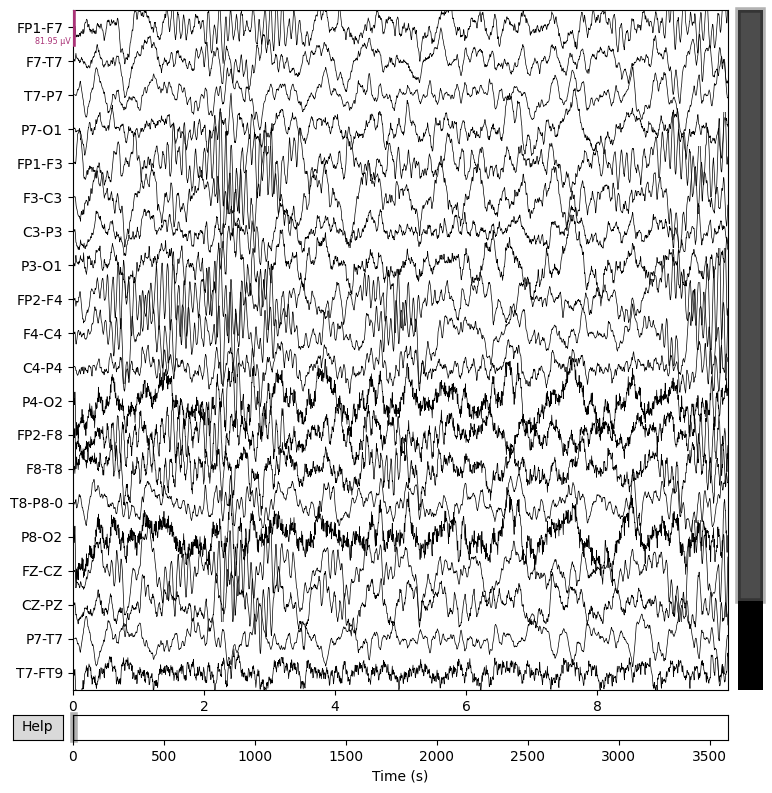

In [ ]:
import matplotlib.pyplot as plt

#get duration in seconds
duration_sec = raw.n_times / raw.info['sfreq']
print(f'Recording duration: {duration_sec:.2f} seconds')

#plot the first 10 seconds (2560 samples)
raw.plot(start=0, duration=10, scalings='auto')

**Zoom Into 10 Seconds of One Channel**

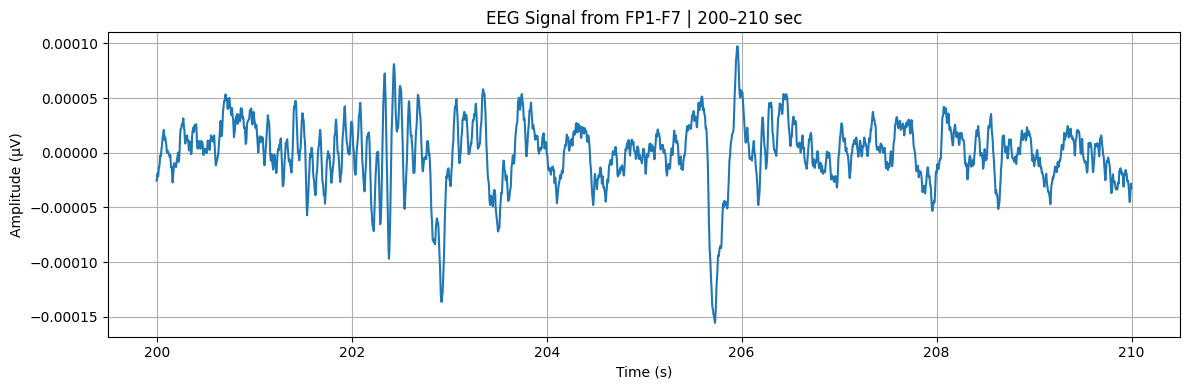

In [ ]:
import numpy as np
#select the EEG channel name to zoom in
channel_name='FP1-F7'
# Get the index of the selected channel
channel_index = raw.ch_names.index(channel_name)

# Get sampling frequency
sfreq = int(raw.info['sfreq'])

# Select a 10-second segment starting at 200 seconds
start_time_sec = 200  # You can adjust this
end_time_sec = start_time_sec + 10

# Convert to sample indices
start_sample = int(start_time_sec * sfreq)
end_sample = int(end_time_sec * sfreq)

# Extract the data
data, times = raw[channel_index, start_sample:end_sample]

# Plot the zoomed segment
plt.figure(figsize=(12, 4))
plt.plot(times, data[0])
plt.title(f"EEG Signal from {channel_name} | {start_time_sec}–{end_time_sec} sec")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Extract 10-Second Windows and Label Them**

In [ ]:


def extract_windows(raw, seizure_start, window_sec=10, step_sec=5, pre_seizure_minutes=10):
    sfreq = int(raw.info['sfreq'])  # Sampling frequency (Hz)
    window_samples = window_sec * sfreq
    step_samples = step_sec * sfreq
    data = raw.get_data()  # shape: (n_channels, n_samples)

    pre_seizure_start = seizure_start - (pre_seizure_minutes * 60)
    pre_seizure_end = seizure_start

    X = []  # feature windows
    y = []  # labels

    # --- 1. Pre-seizure windows ---
    for start in range(pre_seizure_start * sfreq, pre_seizure_end * sfreq - window_samples, step_samples):
        window = data[:, start:start + window_samples]
        X.append(window)
        y.append(1)  # label = pre-seizure

    # --- 2. Non-seizure windows (e.g., before pre-seizure starts) ---
    non_seizure_end = pre_seizure_start - 60  # leave 1-min buffer
    non_seizure_start = max(0, non_seizure_end - (pre_seizure_minutes * 60))

    for start in range(non_seizure_start * sfreq, non_seizure_end * sfreq - window_samples, step_samples):
        window = data[:, start:start + window_samples]
        X.append(window)
        y.append(0)  # label = non-seizure

    return np.array(X), np.array(y)


In [ ]:
# Get seizure start time from parsed summary
seizure_start_time = seizure_info['chb01_03.edf'][0]['start']  # e.g., 2996

# Extract windows and labels
X, y = extract_windows(raw, seizure_start=seizure_start_time)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label distribution:", np.bincount(y))

X shape: (236, 23, 2560)
y shape: (236,)
Label distribution: [118 118]


| Item      | Value                                                              |
| --------- | ------------------------------------------------------------------ |
| `X.shape` | `(236, 23, 2560)`                                                  |
| Meaning   | 236 EEG windows, each with 23 channels × 10 seconds                |
| `y.shape` | `(236,)`                                                           |
| Labels    | 118 pre-seizure (1), 118 non-seizure (0) — **perfectly balanced!** |


**Extract Features from Each Window**

We need to trasform each 23 × 2560 window into a flat feature vector using basic statistical features per channel:

For each channel in a window, we’ll extract:

Mean

Standard Deviation

Variance

Minimum

Maximum

This will give us:

5 features × 23 channels = 115 features per window

In [ ]:
def extract_features(X_windows):
    features = []
    for window in X_windows:
        feature_vector = []
        for channel in window:  # shape: (2560,)
            mean_val = np.mean(channel)
            std_val = np.std(channel)
            var_val = np.var(channel)
            min_val = np.min(channel)
            max_val = np.max(channel)
            # Append all features for this channel
            feature_vector.extend([mean_val, std_val, var_val, min_val, max_val])
        features.append(feature_vector)
    return np.array(features)


In [ ]:
# Extract statistical features from X
X_features = extract_features(X)

# Check shape
print("X_features shape:", X_features.shape)


X_features shape: (236, 115)


**Train a Random Forest Model**

Split the data into train/test sets (80% / 20%)

Train a RandomForestClassifier

Evaluate with accuracy, confusion matrix, and classification report

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate
print(" Accuracy:", accuracy_score(y_test, y_pred))

 Accuracy: 0.8333333333333334


In [ ]:
print("\n Classification Report:\n", classification_report(y_test, y_pred))



 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84        24
           1       0.86      0.79      0.83        24

    accuracy                           0.83        48
   macro avg       0.84      0.83      0.83        48
weighted avg       0.84      0.83      0.83        48



Precision = Of all predicted pre-seizure, how many were correct?

Recall = Of all actual pre-seizure windows, how many did we catch?

F1-score = Balance between precision and recall

In [ ]:
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Confusion Matrix:
 [[21  3]
 [ 5 19]]


| Metric       | Value        | Meaning                                                                                |
| ------------ | ------------ | -------------------------------------------------------------------------------------- |
| **Accuracy** | **83.33%**   | Overall, 83% of the test samples were classified correctly.                            |
| **Support**  | 24 per class | I had 24 **pre-seizure** and 24 **non-seizure** samples in my test set (balanced). |


           Predicted
           0    1
       0  [21   3] → True Non-Seizure: 21, False Positive: 3     
       1  [ 5  19] → False Negative: 5, True Pre-Seizure: 19

21 Non-Seizure windows correctly predicted (True Negative)

19 Pre-Seizure windows correctly predicted (True Positive)

3 False Positives → Non-Seizure predicted as Pre-Seizure

5 False Negatives → Pre-Seizure missed (risk of missing a seizure)






**Train and Evaluate an SVM Model**

In [ ]:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train SVM
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate
print(" SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


 SVM Accuracy: 0.7083333333333334


In [ ]:
print("\n SVM Classification Report:\n", classification_report(y_test, y_pred_svm))



 SVM Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.62      0.68        24
           1       0.68      0.79      0.73        24

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48



In [ ]:
print("\n SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))



 SVM Confusion Matrix:
 [[15  9]
 [ 5 19]]


**Train a Neural Network (MLP Classifier)**

It's a Multilayer Perceptron (MLP) — a simple feedforward neural network

Great for tabular data like your features

In [ ]:
from sklearn.neural_network import MLPClassifier
#initialize MPL
mlp_model = MLPClassifier(hidden_layer_sizes=(64,32),
                          activation='relu',
                          solver='adam',
                          max_iter=500,
                          random_state=42)
#train the model
mlp_model.fit(X_train, y_train)

#predict
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate
print(" MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))

✅ MLP Accuracy: 0.5


In [ ]:
print("\n MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))


 MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.50      1.00      0.67        24

    accuracy                           0.50        48
   macro avg       0.25      0.50      0.33        48
weighted avg       0.25      0.50      0.33        48



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n MLP Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


 MLP Confusion Matrix:
 [[ 0 24]
 [ 0 24]]


The result are not cool so lets try a good approach, where it has predicted everthing as pre-seisure

**Scale Features and Retrain MLP**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP again on scaled data
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          solver='adam', max_iter=500, random_state=42)

mlp_model.fit(X_train_scaled, y_train)

# Predict
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate
print(" MLP Accuracy (with scaling):", accuracy_score(y_test, y_pred_mlp))
print("\n MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("\n MLP Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


 MLP Accuracy (with scaling): 0.8541666666666666

 MLP Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.84      0.88      0.86        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48


 MLP Confusion Matrix:
 [[20  4]
 [ 3 21]]


**FINE-TUNE FOR HIGHER ACCURACY**

Use **Grid Search for MLP**to try many combinations. (GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

mlp_grid = MLPClassifier(max_iter=1000, random_state=42)

grid_search = GridSearchCV(mlp_grid, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}


In [ ]:
print("Best Score (Train CV):", grid_search.best_score_)

Best Score (Train CV): 0.8616658132787166


In [ ]:
# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test_scaled)

print("\nAccuracy (Tuned MLP):", accuracy_score(y_test, y_pred_grid))
print("\n Classification Report:\n", classification_report(y_test, y_pred_grid))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_grid))


Accuracy (Tuned MLP): 0.8541666666666666

 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.84      0.88      0.86        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48


 Confusion Matrix:
 [[20  4]
 [ 3 21]]


#**Combine Multiple .edf Files into One Dataset**

In [ ]:
edf_paths = [
    '/content/chb01_03.edf',
    '/content/chb01_04.edf',
    '/content/chb01_15.edf',
    '/content/chb01_16.edf'
]

combined_X = []
combined_y = []

for path in edf_paths:
    file_name = os.path.basename(path)

    if file_name in seizure_info:
        print(f"\n Processing: {file_name}")

        # Load EEG data
        raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)

        # Loop through all seizure events in the file (some files have multiple seizures)
        for seizure_event in seizure_info[file_name]:
            seizure_start_time = seizure_event['start']

            # Step 1: Extract 10s windows from pre-seizure & non-seizure periods
            X_win, y_win = extract_windows(raw_file, seizure_start=seizure_start_time)

            # Step 2: Extract statistical features from each window
            X_feats = extract_features(X_win)

            # Step 3: Append to combined dataset
            combined_X.append(X_feats)
            combined_y.append(y_win)

# Combine all arrays into one dataset
X_combined = np.vstack(combined_X)
y_combined = np.hstack(combined_y)

print("\n Combined Dataset:")
print("X_combined shape:", X_combined.shape)
print("y_combined shape:", y_combined.shape)
print("Label Distribution:", np.bincount(y_combined))



 Processing: chb01_03.edf


/tmp/ipython-input-23-3559086580.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_04.edf


/tmp/ipython-input-23-3559086580.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_15.edf


/tmp/ipython-input-23-3559086580.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_16.edf


/tmp/ipython-input-23-3559086580.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Combined Dataset:
X_combined shape: (895, 115)
y_combined shape: (895,)
Label Distribution: [423 472]


| Metric             | Value        |
| ------------------ | ------------ |
| Total Windows      | **895**      |
| Non-Seizure (0)    | 423 windows  |
| Pre-Seizure (1)    | 472 windows  |
| Feature Dimensions | 115 features |


#**Train MLP on the Combined Dataset**

I'll:

Scale the full dataset

Split into training and testing

Train the MLPClassifier (with your best parameters)

Evaluate performance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

# Step 2: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train MLP with best found params
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

# Step 4: Predict & Evaluate
y_pred_mlp = mlp_model.predict(X_test_scaled)

print("MLP Accuracy (Combined Data):", accuracy_score(y_test, y_pred_mlp))
print("\n Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


MLP Accuracy (Combined Data): 0.7206703910614525

 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71        85
           1       0.74      0.71      0.73        94

    accuracy                           0.72       179
   macro avg       0.72      0.72      0.72       179
weighted avg       0.72      0.72      0.72       179


 Confusion Matrix:
 [[62 23]
 [27 67]]


#**Build a CNN on Raw EEG Windows**

We'll:

Reshape the input to N x 23 x 2560 x 1 (add channel dim)

Build a 2D CNN using Keras

Train and evaluate

**Collect Raw EEG Windows for CNN**

In [ ]:
raw_windows = []
raw_labels = []

for path in edf_paths:
    file_name = os.path.basename(path)

    if file_name in seizure_info:
        print(f"\n Processing: {file_name}")

        raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)

        for seizure_event in seizure_info[file_name]:
            seizure_start_time = seizure_event['start']

            X_win, y_win = extract_windows(raw_file, seizure_start=seizure_start_time)

            raw_windows.append(X_win)
            raw_labels.append(y_win)

# Stack into full dataset
X_raw = np.vstack(raw_windows)  # Shape: (N, 23, 2560)
y_raw = np.hstack(raw_labels)



 Processing: chb01_03.edf


/tmp/ipython-input-67-1270878191.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_04.edf


/tmp/ipython-input-67-1270878191.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_15.edf


/tmp/ipython-input-67-1270878191.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)



 Processing: chb01_16.edf


/tmp/ipython-input-67-1270878191.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_file = mne.io.read_raw_edf(path, preload=True, verbose=False)


In [ ]:
X_cnn = X_raw[..., np.newaxis]  # (N, 23, 2560, 1)


In [ ]:
print("X_cnn shape:", X_cnn.shape)
print("y_raw shape:", y_raw.shape)
print("Label Distribution:", np.bincount(y_raw))

X_cnn shape: (895, 23, 2560, 1)
y_raw shape: (895,)
Label Distribution: [423 472]


#**Train the CNN model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build CNN
cnn_model = Sequential([
    Conv2D(32, (3, 5), activation='relu', input_shape=(23, 2560, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 4)),

    Conv2D(64, (3, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 4)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 21, 2556, 32)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 2556, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 639, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 635, 64)    │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 635, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 158, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    24,592,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,624,321 (93.93 MB)

 Trainable params: 24,624,129 (93.93 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Split the CNN-ready data
from sklearn.model_selection import train_test_split

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# Train the CNN model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=10,
    batch_size=16,
    verbose=1
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate accuracy
loss, acc = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"\n CNN Test Accuracy: {acc:.2f}")

# Predict probabilities, then convert to class labels
y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Classification report
print("\n Classification Report:\n", classification_report(y_test_cnn, y_pred_labels))

# Confusion matrix
print("\n Confusion Matrix:\n", confusion_matrix(y_test_cnn, y_pred_labels))


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 893ms/step - accuracy: 0.4471 - loss: 9.1768

✅ CNN Test Accuracy: 0.47
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64        85
           1       0.00      0.00      0.00        94

    accuracy                           0.47       179
   macro avg       0.24      0.50      0.32       179
weighted avg       0.23      0.47      0.31       179


📉 Confusion Matrix:
 [[85  0]
 [94  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9953 - loss: 0.0227 - val_accuracy: 0.5251 - val_loss: 149.0866
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.9802 - loss: 0.0435 - val_accuracy: 0.5251 - val_loss: 119.9486
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9941 - loss: 0.0303 - val_accuracy: 0.4749 - val_loss: 142.7399
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 0.4749 - val_loss: 555.0833
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9986 - loss: 0.0120 - val_accuracy: 0.4749 - val_loss: 848.7550
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9934 - loss: 0.0217 - val_accuracy: 0.4749 - val_loss: 371.7794
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9989 - loss: 0.0083 - val_accuracy: 0.5251 - val_loss: 35.8979
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9959 - loss: 0.0138 - val_accurac

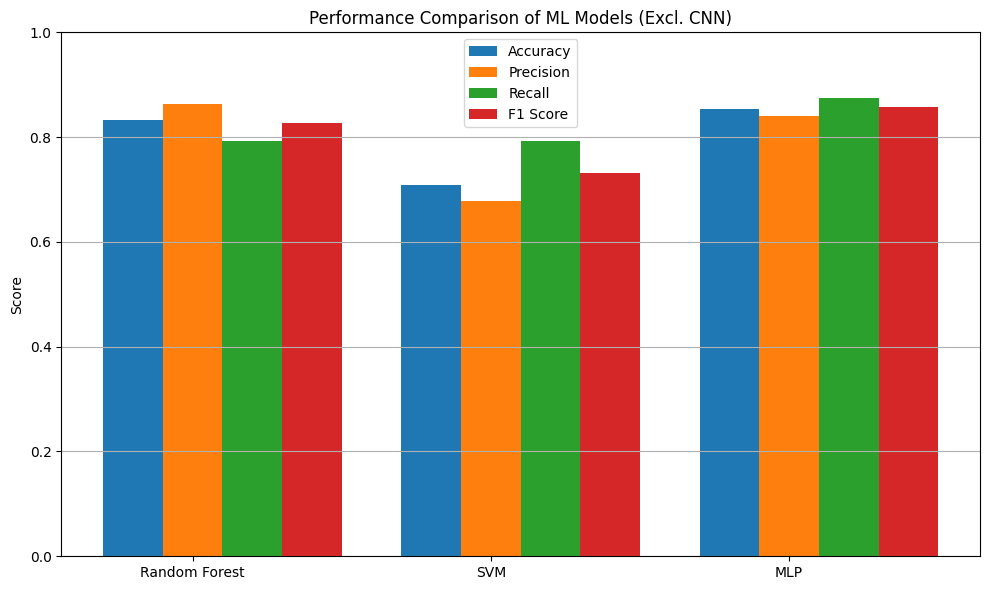

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define models and their predictions
model_names = ['Random Forest', 'SVM', 'MLP']
model_preds = [
    rf_model.predict(X_test),
    svm_model.predict(X_test),
    mlp_model.predict(X_test_scaled)
]

# True labels
y_true = y_test

# Collect metrics
accuracies = [accuracy_score(y_true, y_pred) for y_pred in model_preds]
precisions = [precision_score(y_true, y_pred) for y_pred in model_preds]
recalls = [recall_score(y_true, y_pred) for y_pred in model_preds]
f1s = [f1_score(y_true, y_pred) for y_pred in model_preds]

# Create grouped bar chart
x = range(len(model_names))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar([p - width for p in x], accuracies, width, label='Accuracy')
plt.bar(x, precisions, width, label='Precision')
plt.bar([p + width for p in x], recalls, width, label='Recall')
plt.bar([p + 2*width for p in x], f1s, width, label='F1 Score')

plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.title("Performance Comparison of ML Models (Excl. CNN)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save the MLP model
joblib.dump(mlp_model, 'best_mlp_model.joblib')

# Also save the scaler for preprocessing at inference time
joblib.dump(scaler, 'mlp_scaler.joblib')

print("MLP model and scaler saved successfully.")


✅ MLP model and scaler saved successfully.
